# Project: Insights and visalizations derived from wrangled/cleaned WeRateDogs data (Part 2/2)


## Table of Contents:

1. [Introduction](#intro)
2. [Insights and visualizations derived to answer the research questions](#insights)


<a id='intro'></a>
# 1. Introduction


This project focused on wrangling data from the WeRateDogs Twitter account using Python, documented in a Jupyter Notebook (`wrangle_act_v1.0_DIRK.ipynb`). This Twitter account rates dogs with humorous commentary. The rating denominator is usually 10, however, the numerators are usually greater than 10. They’re Good Dogs Brent wrangles WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. WeRateDogs has over 4 million followers and has received international media coverage.

WeRateDogs downloaded their Twitter archive and sent it to Udacity via email exclusively for us to use in this project. This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets as they stood on August 1, 2017.

The goal of this project is to wrangle the WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The challenge lies in the fact that the Twitter archive is great, but it only contains very basic tweet information that comes in JSON format. 

In part 1 of this project I gathered, assessed and cleaned the Twitter data as input dataset for a worthy analysis and visualization. This report comprises part 2 of the project and focuses on **communicating the gained insights and visualizations**. 

The output report of this part 1 of the project is the `wrangle_report_DIRK_KADIJK.ipynb` file which describes the data wrangling/cleaning efforts and outputs. The output datafile of the data wrangling/cleaning part 1 is a `twitter_overall_table` pandas dataframe which is saved in the `twitter_archive_master.csv` file. This file is the input file for this report (see next table below).


<br><br>
## 1.1. Data Wrangling/cleaning part 1 of the project

In the wrangling/cleaning part (1/2) of the project we gathered 3 pieces of data and transformed that to the `twitter_overall_table`:

### a. Enhanced Twitter Archive

The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which I used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced.". We manually downloaded this twitter_archive_enhanced.csv file by clicking the following [link](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv). 

### b. Image Predictions File

The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) hosted on Udacity's servers and we downloaded it programmatically using python Requests library AND the following URL of the file: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv)

### c. Twitter API

Back to the basic-ness of Twitter archives: retweet count and favorite count are two of the notable column omissions. Fortunately, this additional data can be gathered by anyone from Twitter's API. Well, "anyone" who has access to data for the 3000 most recent tweets, at least. But we, because we have the WeRateDogs Twitter archive and specifically the tweet IDs within it, can gather this data for all 5000+.
In this project, I'll be using Tweepy to query Twitter's API for data included in the WeRateDogs Twitter archive. This data will include retweet count and favorite count.



<br><br>The following Python packages are used in this project:


In [38]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import tweepy
import json
from timeit import default_timer as timer
from tweepy import OAuthHandler

<br><br>
The table below illustrates a subset of the following 10 most important columns in the `twitter_overall_table`:
* **tweet_id**: identifier of WeRateDogs tweet
* **rating_numerator**: score of dogs on a scale 10 - 15
* **rating_denominator**: default reference norm with value 10
* **name**: name of dog in tweet
* **stage**: stage in development of dog based on a WeRateDogs classification scheme (value are: doggo, pupper, puppo, floofer)
* **retweet_count**: count of retweet of this tweet
* **favorite_count**: count of favorite of this tweet
* **predicted_dograce1**: the best (#1) neural network algo prediction of dograce (dog breed) for the image in the tweet 
* **pred_confid1**: is how confident the algo is in its #1 prediction
* **pred_dog1**: is wether or not the #1 prediction is a breed of dog


In [39]:
twitter_overall_table = pd.read_csv('twitter_archive_master.csv', encoding='utf-8')
twitter_overall_table.iloc[:, np.r_[:1, 5:11, 13:16]].head(10)

,tweet_id,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,predicted_dograce1,pred_confid1,predicted_dog1
0,892420643555336193,13.0,10,Phineas,NaN,8853,39467,Orange,0.097049,False
1,892177421306343426,13.0,10,Tilly,NaN,6514,33819,Chihuahua,0.323581,True
2,891815181378084864,12.0,10,Archie,NaN,4328,25461,Chihuahua,0.716012,True
3,891689557279858688,13.0,10,Darla,NaN,8964,42908,Paper_towel,0.170278,False
4,891327558926688256,12.0,10,Franklin,NaN,9774,41048,Basset,0.555712,True
5,891087950875897856,13.0,10,NaN,NaN,3261,20562,Chesapeake_bay_retriever,0.425595,True
6,890971913173991426,13.0,10,Jax,NaN,2158,12041,Appenzeller,0.341703,True
7,890729181411237888,13.0,10,NaN,NaN,16716,56848,Pomeranian,0.566142,True
8,890609185150312448,13.0,10,Zoey,NaN,4429,28226,Irish_terrier,0.487574,True
9,890240255349198849,14.0,10,Cassie,doggo,7711,32467,Pembroke,0.511319,True


<br><br>
## 1.2. Research Questions

This investigation of WeRateDogs data is focused on the following 3 research questions:
* Research Question #1: To what extend is there a possitive correlation between a high rating_numerator at the one end, and a higher favorite_count (or retweet_count) at the other hand.

* Research Question #2: Does filtering out of the "non-dog" predictions and the #1 predictions with probability <70% improve the correlation between rating_numerator and retweet_count / favorite_count? 

* Research Question #3: Which dograces (dog breeds) are top performing in terms of rating_numerator ?¶ 



<a id='insights'></a>
# 2. Insights and visualizations derived which answer the research questions

## 2.1. RESEARCH QUESTION #1: To what extend is there a possitive correlation between a high rating_numerator at the one end, and a higher favorite_count (or retweet_count) at the other hand?

The summarized outcomes of the analysis are:

* Only dograce #1 prediction has some predictive power: 50% of the dograce number #1 predictions have a confidence of less than 59%.
* There is only a `moderate` positive correlation (0.3-0.4)  between rating_numerator at the one end, and a favorite_count (or retweet_count) at the other hand.
* WeRateDogs score < 10 got never retweeted >10000 times.
* WeRateDogs score < 10 got only favorite_count > 20000 in only 3 single cases, which can be explained with that 2 were not #1 predicted as dog while the third case has just a probability of 0.46. 

<br><br>See below for specifics of the analysis and the visualizations:

In [40]:
twitter_overall_table.describe()

,tweet_id,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,pred_confid1,pred_confid2,pred_confid3
count,2.078000e+03,2078.000000,2078.0,2078.000000,2078.000000,1952.000000,1952.000000,1.952000e+03,1.952000e+03
mean,7.367280e+17,10.610577,10.0,2842.781039,9004.178056,1.202357,0.594351,1.349446e-01,6.011246e-02
std,6.726320e+16,2.149876,0.0,4718.678406,12237.183241,0.559650,0.272239,1.012024e-01,5.083426e-02
min,6.660209e+17,0.000000,10.0,16.000000,81.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.767853e+17,10.000000,10.0,641.500000,2041.750000,1.000000,0.362775,5.352722e-02,1.595832e-02
50%,7.097095e+17,11.000000,10.0,1402.500000,4199.500000,1.000000,0.587635,1.178485e-01,4.941030e-02
75%,7.881228e+17,12.000000,10.0,3289.500000,11463.250000,1.000000,0.847062,1.963337e-01,9.157912e-02
max,8.924206e+17,14.000000,10.0,79515.000000,132810.000000,4.000000,1.000000,4.880140e-01,2.710420e-01


The cel above tells that only dograce #1 prediction has some predictive power:
- 50% of the dograce number #1 predictions have a confidence of less than 59%.
- Note: there is not any #2 prediction with a confidence of more than 48% (and #3 predictions even less confident)




<br><br>
Let us  now determine the level of correlation between rating_numerator, favorite_count and retweet_count:

In [41]:
twitter_overall_table [[ 'rating_numerator','retweet_count', 'favorite_count']].corr()

,rating_numerator,retweet_count,favorite_count
rating_numerator,1.000000,0.313879,0.413777
retweet_count,0.313879,1.000000,0.911327
favorite_count,0.413777,0.911327,1.000000


As one may expect there is a high (0.91) correlation between favorite_count and retweet_count.

However it shows that the level of correlation between rating_numerator and resp. retweet_count and favorite_count is only `moderate` (score is resp. 0.3 and 0.4 which significantly less than the norm (>= 0.7) for 'high' correlation. <br><br>


Let us now try to visualize the relationship between rating_numerator and `favorite_count`:

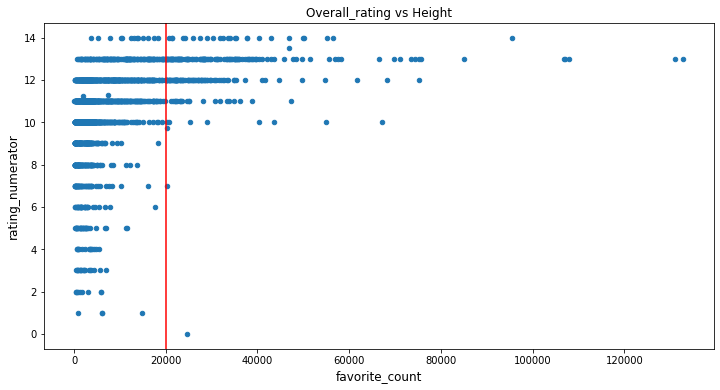

In [42]:
twitter_overall_table.plot(x=['favorite_count'],y=['rating_numerator'],figsize=(12,6), title='Overall_rating vs Height', marker='o', kind='scatter');
plt.ylabel('rating_numerator', fontsize=12)
plt.xlabel('favorite_count', fontsize=12);
plt.axvline(20000, c='red');

The scatter diagram above makes clear that a rating_numerator lower than 10 correlates with a favorite_count of lower than 20000. 3 dogs are the exceptions of which 2 cases were not #1 predicted as dog while the third case had just a probability of 0.46.

So the probability that a dog with low WeRateDogs-score (<10) gets a favorite_count > 20000 is quite low.


<br><br>The same finding do we get for the `retweet_count`. The diagram below tells that dogs with a "WeRateDogs' score < 10 never got retweeted >10000 times:

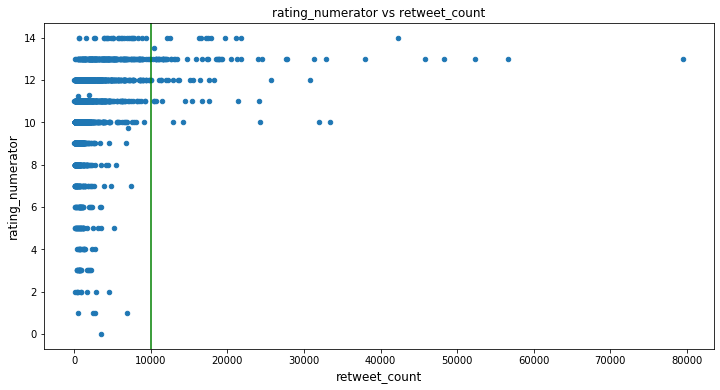

In [57]:
twitter_overall_table.plot(x=['retweet_count'],y=['rating_numerator'],figsize=(12,6), title='rating_numerator vs retweet_count', marker='o', kind='scatter');
plt.ylabel('rating_numerator', fontsize=12)
plt.xlabel('retweet_count', fontsize=12);
plt.axvline(10000, c='green');

<br><br>
## 2.2. Research Question #2: Does filtering out of the "non-dog" predictions and the #1 predictions with probability <70% improve the correlation between rating_numerator and retweet_count / favorite_count?


The summarized outcomes of the analysis are:
* Taking out observations of non_dogs does NOT or hardly improve the correlation rating_numerator and favorite_count/retweet_count: only +2-4%.
* Taking out observations with #1 prediction probability < 70% does NOT improve the correlation between rating_numerator and retweet_count (even degrades from 0.34 to 0.33).
* Visual inspections learns that taking out non-dog predictions and low probability #1 predictions is usefull to clean up outliers due to dirty data.

<br><br>See below for specifics of the analysis and the visualizations:

In [44]:
pd.set_option('display.max_colwidth', 25)
twitter_overall_table_dog_only = twitter_overall_table[twitter_overall_table['predicted_dog1'] == True]

See first here again the correlation matrix with ALL rows for all observations:

In [58]:
twitter_overall_table [[ 'rating_numerator','retweet_count', 'favorite_count']].corr()

,rating_numerator,retweet_count,favorite_count
rating_numerator,1.000000,0.313879,0.413777
retweet_count,0.313879,1.000000,0.911327
favorite_count,0.413777,0.911327,1.000000


And here the correlation with the non-dog predictions taken out:

In [46]:

twitter_overall_table_dog_only [[ 'rating_numerator','retweet_count', 'favorite_count']].corr()

,rating_numerator,retweet_count,favorite_count
rating_numerator,1.000000,0.341517,0.456930
retweet_count,0.341517,1.000000,0.910982
favorite_count,0.456930,0.910982,1.000000


Cel above tells that correlation hardly improves by taking out the non-dog predictions: only +2-4%.




Let us now take out also the #1 predictions with probability <70% (besides the #1 non-dog predictions already taken out).

Taking out observations with probability < 70% does NOT improve the correlation between rating_numerator and retweet_count (even degrades from 0.34 to 0.33).

In [59]:
twitter_overall_table_dog_confident = twitter_overall_table_dog_only[twitter_overall_table_dog_only['pred_confid1'] > 0.7]
twitter_overall_table_dog_confident [[ 'rating_numerator','retweet_count', 'favorite_count']].corr()

,rating_numerator,retweet_count,favorite_count
rating_numerator,1.000000,0.329381,0.457275
retweet_count,0.329381,1.000000,0.892012
favorite_count,0.457275,0.892012,1.000000


Let us also here do a visual check:

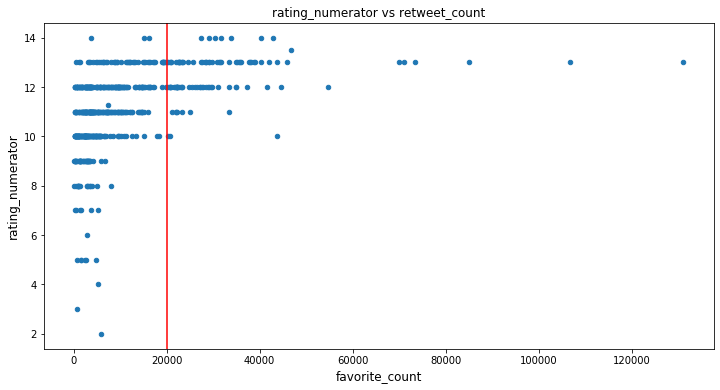

In [50]:
twitter_overall_table_dog_confident.plot(x=['favorite_count'],y=['rating_numerator'],figsize=(12,6), title='rating_numerator vs retweet_count', marker='o', kind='scatter');

plt.ylabel('rating_numerator', fontsize=12)
plt.xlabel('favorite_count', fontsize=12);
plt.axvline(20000, c='red');

Visual inspection learns that taking out non-dog predictions and low probability #1 predictions is usefull to clean up outliers due to dirty data.

### 2.3. Research Question #3: Which dograces (dog breeds) are top performing in terms of rating_numerator ?

<img src="https://pbs.twimg.com/media/DFYRgsOUQAARGhO.jpg" width="400" height="400" />

The summarized outcomes of the analysis are:
* The top 3 top performing dog breeds in terms of WeRateDog rating_numerator score (between 10-15) is:
  1. Golden_retriever (see visual above this cel)
  2. Pembroke
  3. Labrador_retriever
* Note: See below a plot with the top 10 performing dogs and the specific scores on y-axis
* At the end you can also find a lookup table where you can find the top 'WeRateDogs' scores per dograce (dog breed)

See below for specifics of the analysis and the visualizations:

<br><br>We have the following top 20 rating of dograces (dog breeds), after correction for non-dog predictions and predictions with <70% probability:

In [51]:
twitter_overall_table_dog_confident.query('rating_numerator >= 10')  ['predicted_dograce1'].value_counts().head(10)


Golden_retriever      80
Pembroke              50
Labrador_retriever    44
Pug                   28
Chihuahua             25
Samoyed               24
Pomeranian            23
Chow                  19
Toy_poodle            14
French_bulldog        14
Name: predicted_dograce1, dtype: int64

If we focus on only the very high (>= 12) WeRateDogs scores we see that Samoyed climps to position 4 and Pug sinks to position 10 (so Pug had many 10 or 11 scores).

In [52]:
twitter_overall_table_dog_confident.query('rating_numerator >= 12')  ['predicted_dograce1'].value_counts().head(10)

Golden_retriever      58
Pembroke              29
Labrador_retriever    24
Samoyed               15
Chihuahua             14
Chow                  12
French_bulldog         9
Pomeranian             8
German_shepherd        7
Toy_poodle             7
Name: predicted_dograce1, dtype: int64

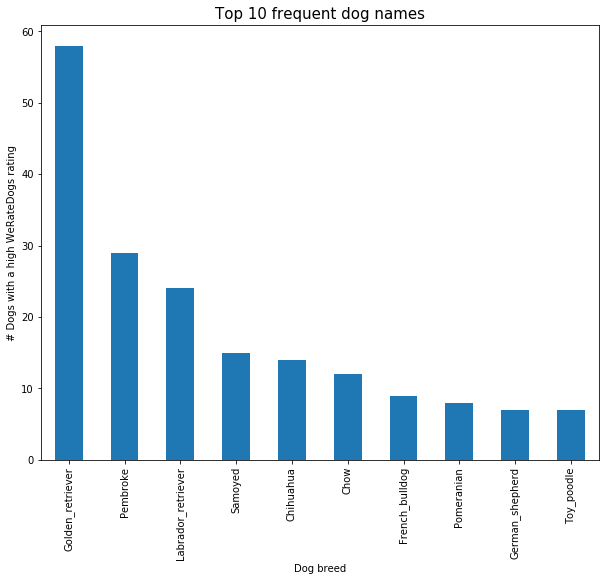

In [61]:
twitter_overall_table_dog_confident.query('rating_numerator >= 12')  ['predicted_dograce1'].value_counts().head(10).plot(kind='bar', figsize=(10,8));
plt.ylabel('# Dogs with a high WeRateDogs rating')
plt.title('Top 10 frequent dog names', size=15)
plt.xlabel('Dog breed')
plt.plot();

In [60]:
twitter_overall_table_dog_confident = twitter_overall_table_dog_confident[twitter_overall_table_dog_confident['rating_numerator'] >= 10 ]

Finally see here also a lookup table where you can look up the top 'WeRateDogs' scores per dograce:

In [56]:
pd.set_option('display.max_rows', 3000)
twitter_overall_table_dog_confident.groupby(['predicted_dograce1','rating_numerator']) ['tweet_id'].count()  .unstack().fillna(0) 

rating_numerator,10.00,11.00,11.27,12.00,13.00,13.50,14.00
predicted_dograce1,,,,,,,
Afghan_hound,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Airedale,1.0,2.0,0.0,1.0,0.0,0.0,0.0
American_staffordshire_terrier,2.0,1.0,0.0,1.0,1.0,0.0,0.0
Basenji,0.0,1.0,0.0,1.0,0.0,0.0,0.0
Basset,2.0,1.0,0.0,1.0,2.0,0.0,0.0
Beagle,0.0,1.0,0.0,1.0,1.0,0.0,0.0
Bernese_mountain_dog,2.0,1.0,0.0,4.0,0.0,0.0,0.0
Black-and-tan_coonhound,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Blenheim_spaniel,1.0,1.0,0.0,3.0,0.0,0.0,0.0
